# create_db_2.ipynb

**TODO**

* add damage level to df_boxes
* transform box coordinates

This notebook generates annotated images with coconut palms surrounded by color coded rectangles and v-shaped cuts surrounded by ellipses.

Input data includes the raw image and a corresponding pickle file containing a dict generated by **detect_crb_damage.ipynb**

dict stored in **../rawdata/IMG_20231007_110848.pkl**:

    {'filename': '../rawdata/IMG_20231007_110848.jpg', 'width': 1920, 'height': 1080, 'boxes': array([[[0.        , 0.12008591, 0.7371665 , 0.38947737],
            [0.73296094, 0.6885402 , 0.98458767, 0.834793  ],
            [0.18446922, 0.34019256, 0.97027004, 0.73909676],
            [0.09726667, 0.0081338 , 0.6374259 , 0.1931731 ],
            [0.09240278, 0.01155654, 0.6489707 , 0.19037242],
            [0.        , 0.        , 0.        , 0.        ],
            [0.        , 0.        , 0.        , 0.        ],
            [0.        , 0.        , 0.        , 0.        ],
            [0.        , 0.        , 0.        , 0.        ],
            [0.        , 0.        , 0.        , 0.        ],
            [0.        , 0.        , 0.        , 0.        ],
            [0.        , 0.        , 0.        , 0.        ],
            [0.        , 0.        , 0.        , 0.        ],
            [0.        , 0.        , 0.        , 0.        ],
            [0.        , 0.        , 0.        , 0.        ],
            [0.        , 0.        , 0.        , 0.        ],
            [0.        , 0.        , 0.        , 0.        ],
            [0.        , 0.        , 0.        , 0.        ],
            [0.        , 0.        , 0.        , 0.        ],
            [0.        , 0.        , 0.        , 0.        ]]], dtype=float32), 'scores': array([[0.8732229 , 0.8524713 , 0.78001934, 0.69734806, 0.3712643 ,
            0.        , 0.        , 0.        , 0.        , 0.        ,
            0.        , 0.        , 0.        , 0.        , 0.        ,
            0.        , 0.        , 0.        , 0.        , 0.        ]],
          dtype=float32), 'classes': array([[2., 1., 2., 2., 3., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
            1., 1., 1., 1.]], dtype=float32), 'num_detections': array([5.], dtype=float32), 'polygons_result': {'cut': [[25.0, 280.5, 12.0, 280.5, 4.5, 274.0, 2.5, 251.0, 14.5, 224.0, 27.0, 207.5, 52.0, 208.5, 65.5, 219.0, 65.5, 240.0, 50.5, 264.0, 25.0, 280.5], [451.0, 57.5, 426.0, 49.5, 419.5, 43.0, 415.5, 20.0, 421.0, 4.5, 451.0, 3.5, 462.0, 12.5, 474.0, 6.5, 481.5, 7.0, 484.5, 35.0, 464.0, 41.5, 456.5, 55.0, 451.0, 57.5]]}, 'polygons_scores': [0.9608037, 0.90555257]}


In [2]:
import sys
sys.version_info

sys.version_info(major=3, minor=6, micro=9, releaselevel='final', serial=0)

In [3]:
import shapely.geometry

b = shapely.geometry.box(0,0,10,20)
print(b)

POLYGON ((10 0, 10 20, 0 20, 0 0, 10 0))


In [4]:
!pip3 list

Package                 Version
----------------------- -------------------
absl-py                 0.9.0
aiofiles                0.8.0
aiohttp                 3.8.1
aiohttp-retry           2.5.1
aiosignal               1.2.0
aiostream               0.4.4
amply                   0.1.4
ansiwrap                0.8.4
anyio                   2.0.2
appdirs                 1.4.4
apt-clone               0.2.1
apturl                  0.5.2
argon2-cffi             20.1.0
asn1crypto              0.24.0
astor                   0.8.1
async-exit-stack        1.0.1
async-generator         1.10
async-timeout           4.0.2
asynctest               0.13.0
attrs                   21.4.0
Babel                   2.9.0
backcall                0.2.0
bcrypt                  3.1.7
beautifulsoup4          4.6.0
black                   20.8b1
bleach                  3.2.2
Brlapi                  0.6.6
cached-property         1.5.1
certifi                 2020.12.5
cffi                    1.14.4
chardet        

In [5]:
import glob
import pickle
import numpy as np
import cv2
import pandas as pd
pd.set_option('display.width',1000)
import spatialite
import os

# import shapely.geometry

import matplotlib.pyplot as plt 
%matplotlib inline 

In [6]:
def process_pickle_data(pickle_file_path):
    results = {}
    
    original_image_path = pickle_file_path.replace('.pkl', '.jpg')
    results['original_image_path'] = original_image_path
        
    with open(pickle_file_path, 'rb') as f:
        data = pickle.load(f)

    width = data.get('width') 
    results['width'] = width
    
    height = data.get('height')
    results['height'] = height
    
    num_detections = data.get('num_detections')
    
    if not num_detections:
        results['num_detections'] = 0
    else:
        num_detections = int(num_detections[0])
        results['num_detections'] = num_detections

        scores = data.get('scores')[0]
        scores = scores[:num_detections]
        results['scores'] = scores

        boxes = data.get('boxes')[0]
        boxes = boxes[:num_detections]
        results['boxes'] = boxes

        classes = data.get('classes')[0]
        classes = classes.astype(int)
        classes = classes[:num_detections]
        results['classes'] = classes

    polygons_scores = data.get('polygons_scores')
    if not polygons_scores:
        results['num_polygons'] = 0
    else:
        num_polygons = len(polygons_scores)
        results['num_polygons'] = num_polygons
 
        results['polygons_scores'] = polygons_scores
       
        polygons_result = data.get('polygons_result')
        polygons = polygons_result.get('cut')
        polygons = polygons[:num_polygons]    
        results['polygons'] = polygons          
    return results
    
# process_pickle_data('../rawdata/IMG_20231007_110848.pkl')
# process_pickle_data(pickle_files[1])

In [7]:
def draw_shapes(shapes, box_score_threshold=0.5, polygon_score_threshold=0.5):
    """
    INPUT: shapes is the results dict generated by the process_pickle_data function   
    """  
    
    df_boxes = None
    df_polygons = None
        
#     print(shapes)
#     print(box_score_threshold)
    original_image_path = shapes['original_image_path']
    width = shapes['width']
    height = shapes['height']
    
    # Draw boxes around detected coconut palms
    
    num_detections = shapes['num_detections']
    if num_detections == 0:
        return  df_boxes, df_polygons # image is not processed if zero coconut palms were detected

    scores = list(shapes['scores'])
    boxes = list(shapes['boxes'])
    damage_levels = list(shapes['classes'])

#     print('boxes: ', boxes)
    start_points = []
    end_points = []
    mylist = []
    for i, box in enumerate(boxes):
        mylist.append({
            'b_original_image_path': original_image_path,
            'b_score': scores[i], 
            'b_damage_level': damage_levels[i],
            'b_ulx': int(round(box[0]*width)),
            'b_uly': int(round(box[1]*height)),
            'b_lrx': int(round(box[2]*width)),
            'b_lry': int(round(box[3]*height))
        })

    df_boxes = pd.DataFrame(mylist)    
#     df_boxes = df_boxes[df_boxes.b_score >= 0.5]
    
# Draw polygons around v-shaped cuts

    num_polygons = shapes['num_polygons']
    if (num_detections > 0) and (num_polygons > 0):
        polygons = shapes['polygons']
        polygons_scores = shapes['polygons_scores']
        mylist = []
        for i in range(num_polygons):
            points_flt = polygons[i]
            points_int = [int(i) for i in points_flt]           
            points = np.array(points_int, np.int32)
            points_2d = np.reshape(points, (-1, 2))
            
            # calculate bounding box for polygon
             
            s = list(points_2d.flatten())
            xlist = s[0::2]
            ylist = s[1::2]
            ulx = min(xlist)
            uly = min(ylist)
            lrx = max(xlist)
            lry = max(ylist)
                                    
            # polygon is stored as a string to facilitate storage in SQLite. 
            # Use eval() to convert back to a list of integers [x0, y0, x1, y1, ..., x0, y0].
            mylist.append({'p_original_image_path': original_image_path, 
                           'p_score': polygons_scores[i], 
                           'p_polygon': str(s),  
                           'p_ulx': ulx,
                           'p_uly': uly,
                           'p_lrx': lrx,
                           'p_lry': lry
                          })
        df_polygons = pd.DataFrame(mylist)
#         df_polygons = df_boxes[df_boxes.p_score >= 0.5]
            
    return df_boxes, df_polygons
        
#         img = cv2.polylines(img, pts=[points_2d], isClosed=False, color=(0, 255, 255), thickness=2)

In [8]:
def process_detected_objects():
    pickle_files = sorted(glob.glob('../rawdata/*.pkl')) 
    boxes_list = []
    polygons_list = []
    for pickle_file_path in pickle_files:
        shapes = process_pickle_data(pickle_file_path)
        num_detections = shapes['num_detections']
        if num_detections > 0:
            width = shapes['width']
            height = shapes['height']       
            original_image_path = shapes['original_image_path']
            scores = list(shapes['scores'])
            boxes = list(shapes['boxes'])
            damage_levels = list(shapes['classes'])         
            
            for i, box in enumerate(boxes):
                boxes_list.append({
                    'b_original_image_path': original_image_path,
                    'b_score': scores[i], 
                    'b_damage_level': damage_levels[i],
                    'b_ulx': int(round(box[0]*width)),
                    'b_uly': int(round(box[1]*height)),
                    'b_lrx': int(round(box[2]*width)),
                    'b_lry': int(round(box[3]*height))
                })
            
            num_polygons = shapes['num_polygons']
            if num_polygons > 0:
                polygons = shapes['polygons']
                polygons_scores = shapes['polygons_scores']
                for i in range(num_polygons):
                    points_flt = polygons[i]
                    points_int = [int(i) for i in points_flt]           
                    points = np.array(points_int, np.int32)
                    points_2d = np.reshape(points, (-1, 2))

                    # calculate bounding box for polygon

                    s = list(points_2d.flatten())
                    xlist = s[0::2]
                    ylist = s[1::2]
                    ulx = min(xlist)
                    uly = min(ylist)
                    lrx = max(xlist)
                    lry = max(ylist)

                    # polygon is stored as a string to facilitate storage in SQLite. 
                    # Use eval() to convert back to a list of integers [x0, y0, x1, y1, ..., x0, y0].
                    
                    polygons_list.append({
                        'p_original_image_path': original_image_path, 
                        'p_score': polygons_scores[i], 
                        'p_polygon': str(s),  
                        'p_ulx': ulx,
                        'p_uly': uly,
                        'p_lrx': lrx,
                        'p_lry': lry
                    })
                    
        df_boxes = pd.DataFrame(boxes_list)
        df_polygons = pd.DataFrame(polygons_list)
    return df_boxes, df_polygons

# df_boxes, df_polygons = process_detected_objects()
# df_polygons

In [9]:
def find_intersections():
    sql = 'select * from boxes, polygons where b_original_image_path=p_original_image_path'
    df = pd.read_sql_query(sql, con)

    intersection_list = []
    for i, r in df.iterrows():
        box_poly = shapely.geometry.box(r.b_ulx, r.b_uly, r.b_lrx, r.b_lry)    
        s = r.p_polygon
        s = eval(s)
        xlist = s[0::2]
        ylist = s[1::2]
        zipped = zip(xlist, ylist)
        poly = tuple(zipped)
        if len(poly) < 3:
            print(f'ERROR: Number of points in polygon less than 3. p_id: {r.p_id}') # handles a data error
        else:
            poly_poly = shapely.geometry.Polygon(poly)
            if box_poly.intersects(poly_poly):
                intersection_list.append({'b_id': r.b_id, 'p_id': r.p_id})
        df_intersections = pd.DataFrame(intersection_list)
    return df_intersections

# find_intersections()

In [10]:
# MAIN

dbpath = 'mytest.db'
if os.path.isfile(dbpath):
    os.remove(dbpath)

with spatialite.connect(dbpath) as con:
    cursor = con.cursor()    
    cursor.execute("SELECT InitSpatialMetaData(1);")

    # Images table
    ##############
    
    print('Creating images table')   
    cursor.execute("CREATE TABLE images(img_original_image_path, geometry);")
    cursor.execute("SELECT AddGeometryColumn('images', 'geometry', 4326, 'POINT', 'XY');")

    # Read required columns from csv created by extract_gps_data.ipynb
    
    df_img = pd.read_csv('../rawdata/gps-data.csv', usecols=['imagefile', 'longitude_adjusted', 'latitude_adjusted'])
    for i, r in df_img.iterrows():
        original_image_path = f'../rawdata/{r.imagefile}'
        geometry = f'GeomFromText("POINT({r.longitude_adjusted} {r.latitude_adjusted})", 4326)'      
        sql = f'INSERT INTO images(img_original_image_path, geometry) VALUES("{original_image_path}",{geometry});'
        cursor.execute(sql)  

    df_boxes, df_polygons = process_detected_objects()

    # Boxes table (coconut palms)
    #############################
    
    print('creating boxes table')
    
    df_boxes.to_sql('boxes', con, index_label='b_id')

    # polygons table (v-shaped cuts)  
    ################################
    
    print('creating polygons table')
    
    df_polygons.to_sql('polygons', con, index_label='p_id')

    # Intersections table; (b_id, p_id) for each polygon which intercepts a box
    ###########################################################################
    
    print('creating intersections table')
    
    df_intersections = find_intersections()
    df_intersections.to_sql('intersections', con, index_label='i_id')

print('FINISHED')  

Creating images table
creating boxes table
creating polygons table
creating intersections table
ERROR: Number of points in polygon less than 3. p_id: 172
ERROR: Number of points in polygon less than 3. p_id: 172
ERROR: Number of points in polygon less than 3. p_id: 172
ERROR: Number of points in polygon less than 3. p_id: 520
ERROR: Number of points in polygon less than 3. p_id: 520
ERROR: Number of points in polygon less than 3. p_id: 520
ERROR: Number of points in polygon less than 3. p_id: 520
ERROR: Number of points in polygon less than 3. p_id: 520
ERROR: Number of points in polygon less than 3. p_id: 520
ERROR: Number of points in polygon less than 3. p_id: 520
ERROR: Number of points in polygon less than 3. p_id: 520
ERROR: Number of points in polygon less than 3. p_id: 520
ERROR: Number of points in polygon less than 3. p_id: 569
ERROR: Number of points in polygon less than 3. p_id: 569
ERROR: Number of points in polygon less than 3. p_id: 569
ERROR: Number of points in polygon

15915
420


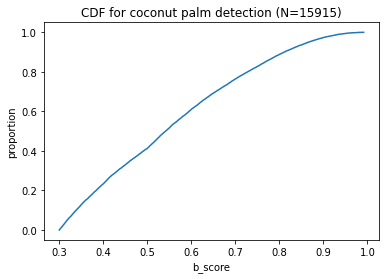

In [11]:
data = df_boxes.b_score
x = np.sort(data)
N = len(x)
print(N)
print(sum(x>0.9))
  
# get the cdf values of y 
y = np.arange(N) / float(N) 
  
# plotting 
plt.xlabel('b_score') 
plt.ylabel('proportion')   
plt.title(f'CDF for coconut palm detection (N={N})')   
plt.plot(x, y); 

1373
838


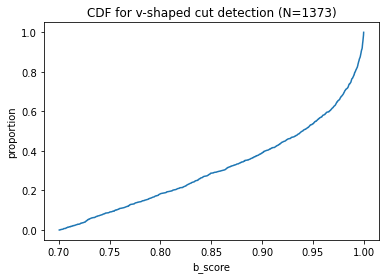

In [12]:
data = df_polygons.p_score
x = np.sort(data)
N = len(x)
print(N)
print(sum(x>0.9))
  
# get the cdf values of y 
y = np.arange(N) / float(N) 
  
# plotting 
plt.xlabel('b_score') 
plt.ylabel('proportion')   
plt.title(f'CDF for v-shaped cut detection (N={N})')   
plt.plot(x, y); 

In [13]:
df_boxes

,b_original_image_path,b_score,b_damage_level,b_ulx,b_uly,b_lrx,b_lry
0,../rawdata/IMG_20231007_110803.jpg,0.832461,1,1499,614,1845,700
1,../rawdata/IMG_20231007_110804.jpg,0.561334,1,1336,673,1777,818
2,../rawdata/IMG_20231007_110811.jpg,0.527260,5,1235,767,1324,788
3,../rawdata/IMG_20231007_110821.jpg,0.706049,2,971,0,1478,96
4,../rawdata/IMG_20231007_110822.jpg,0.534662,2,968,3,1521,92
...,...,...,...,...,...,...,...
15910,../rawdata/IMG_20231007_150614.jpg,0.418254,2,0,759,1342,1074
15911,../rawdata/IMG_20231007_150614.jpg,0.396917,2,749,581,1570,820
15912,../rawdata/IMG_20231007_150614.jpg,0.329963,1,0,764,1315,1067
15913,../rawdata/IMG_20231007_150628.jpg,0.551136,2,1271,976,1698,1078


In [14]:
df_polygons

,p_original_image_path,p_score,p_polygon,p_ulx,p_uly,p_lrx,p_lry
0,../rawdata/IMG_20231007_110848.jpg,0.960804,"[25, 280, 12, 280, 4, 274, 2, 251, 14, 224, 27...",2,207,65,280
1,../rawdata/IMG_20231007_110848.jpg,0.905553,"[451, 57, 426, 49, 419, 43, 415, 20, 421, 4, 4...",415,3,484,57
2,../rawdata/IMG_20231007_110849.jpg,0.909501,"[610, 438, 582, 433, 578, 428, 579, 372, 583, ...",578,367,633,438
3,../rawdata/IMG_20231007_110956.jpg,0.947407,"[985, 177, 963, 172, 951, 160, 956, 128, 964, ...",951,65,1017,177
4,../rawdata/IMG_20231007_111001.jpg,0.867367,"[741, 576, 699, 575, 681, 566, 651, 547, 638, ...",620,373,832,576
...,...,...,...,...,...,...,...
1368,../rawdata/IMG_20231007_150244.jpg,0.764561,"[1327, 385, 1268, 380, 1251, 366, 1246, 355, 1...",1237,128,1494,385
1369,../rawdata/IMG_20231007_150245.jpg,0.721462,"[1479, 707, 1471, 707, 1453, 695, 1449, 671, 1...",1449,623,1521,707
1370,../rawdata/IMG_20231007_150514.jpg,0.888674,"[154, 153, 135, 146, 125, 132, 107, 124, 99, 1...",6,6,160,153
1371,../rawdata/IMG_20231007_150514.jpg,0.887914,"[1006, 122, 969, 119, 957, 111, 951, 89, 954, ...",951,46,1028,122


poly1